In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import kaggle

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download -d mohammadamireshraghi/blood-cell-cancer-all-4class

blood-cell-cancer-all-4class.zip: Skipping, found more recently modified local copy (use --force to force download)


# Unzip data

In [4]:
! unzip -q "blood-cell-cancer-all-4class.zip"

replace Blood cell Cancer [ALL]/Benign/Sap_013 (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Blood cell Cancer [ALL]/Benign/Sap_013 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Set dataset path

In [18]:
datasets_dir = "Blood cell Cancer [ALL]"

# Variable

In [19]:
epochs = 32
IMG_SIZE = 128
BATCH_SIZE = 32

# Dataset Load

In [20]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(42)



train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names


Found 3242 files belonging to 4 classes.
Using 2594 files for training.
Found 3242 files belonging to 4 classes.
Using 648 files for validation.


['Benign', '[Malignant] Pre-B', '[Malignant] Pro-B', '[Malignant] early Pre-B']

# Data augmentation

In [21]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

# Plot images

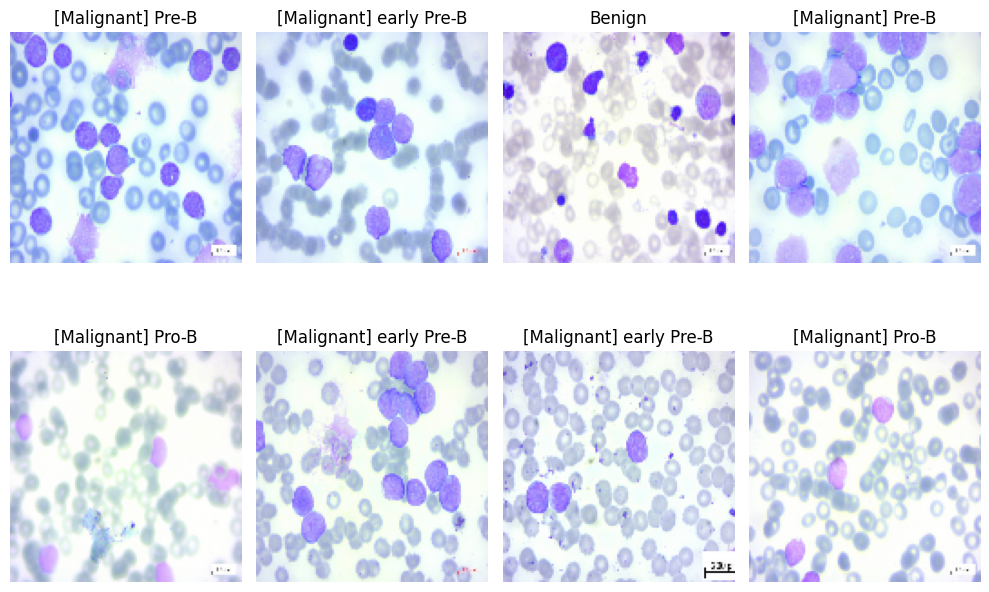

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

# Augmented image view

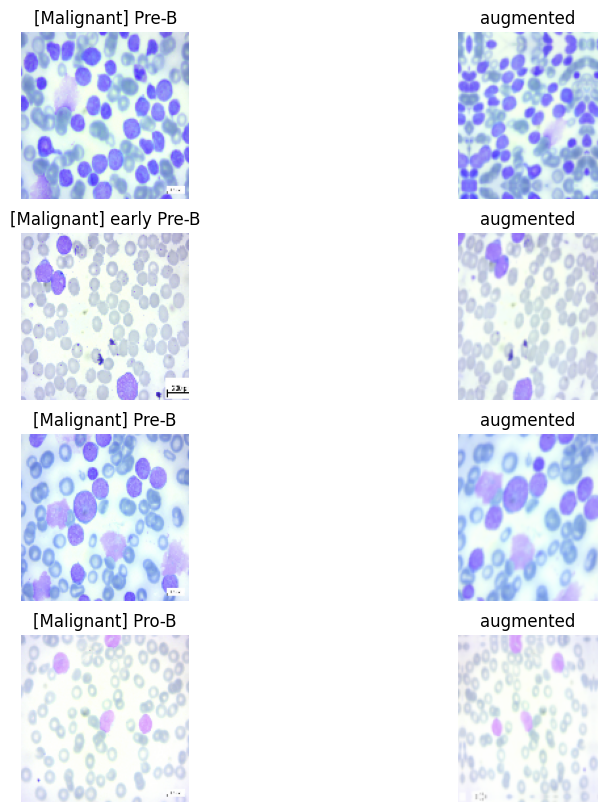

In [24]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        img = augmented_image_batch[i].numpy().astype("uint32")
        plt.imshow(img)
        plt.title(f"augmented")
        plt.axis("off")

## Create checkpoint

In [25]:
# checkpoint_path = "/CheckPoint/"
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path,
#     # save_weights_only=True,
#     monitor='val_accuracy',
#     save_best_only=True
# )


# MOdel. transferlearning. EfficientnetB0

In [58]:
# ResNet 50 model
import keras

model = keras.Sequential()
resnet = keras.applications.ResNet50(
    include_top=False,
    input_shape=(128, 128, 3),
    pooling='avg',
    classes=len(class_names),
    weights='imagenet'
)

for layer in resnet.layers:
  layer.trainable = False

model.add(resnet)
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(256, activation= 'relu'))
# model.add(keras.layers.Dropout(rate= 0.2))
# model.add(keras.layers.Dense(128, activation= 'relu'))
# model.add(keras.layers.Dropout(rate= 0.2))
# model.add(keras.layers.Dense(128, activation= 'relu'))
# model.add(keras.layers.Dropout(rate= 0.2))
# model.add(keras.layers.Dense(64, activation= 'relu'))
model.add(keras.layers.Dense(64, activation= 'relu'))
model.add(keras.layers.Dense(len(class_names), activation='softmax', name='output_layer'))


In [59]:
# import tensorflow as tf

# # Setup the base model and freeze its layers (this will extract features)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable= False

# #Setup model architecture with trainable top layers
# inputs = tf.keras.layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='input_layer')
# x = data_augmentation(inputs)
# x = base_model(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(64, activation= 'relu')(x)
# x = tf.keras.layers.Dense(64, activation= 'relu')(x)
# x = tf.keras.layers.Dense(16, activation= 'relu')(x)
# outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
# model = tf.keras.Model(inputs, outputs)

In [60]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 64)                131136    
                                                                 
 output_layer (Dense)        (None, 4)                 260       
                                                                 
Total params: 23719108 (90.48 MB)
Trainable params: 131396 (513.27 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


# Model ploting

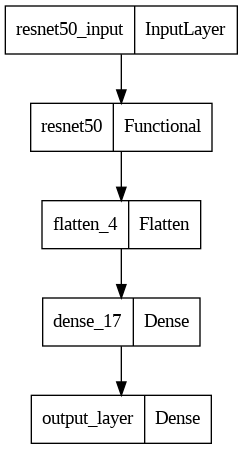

In [61]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

# MOdel compile

In [62]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'],
)

# Model train

In [63]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2)
]
history = model.fit(
    train_data,
    epochs=32,
    validation_data = test_data,
    validation_steps = len(test_data),
    # callbacks = callbacks
)

Epoch 1/32
82/82 [==============================] - 11s 66ms/step - loss: 0.3627 - accuracy: 0.8805 - val_loss: 0.1229 - val_accuracy: 0.9676
Epoch 2/32
82/82 [==============================] - 4s 54ms/step - loss: 0.1350 - accuracy: 0.9534 - val_loss: 0.1540 - val_accuracy: 0.9444
Epoch 3/32
82/82 [==============================] - 4s 49ms/step - loss: 0.0788 - accuracy: 0.9773 - val_loss: 0.0745 - val_accuracy: 0.9738
Epoch 4/32
82/82 [==============================] - 4s 45ms/step - loss: 0.0616 - accuracy: 0.9823 - val_loss: 0.0844 - val_accuracy: 0.9753
Epoch 5/32
82/82 [==============================] - 4s 45ms/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.0724 - val_accuracy: 0.9753
Epoch 6/32
82/82 [==============================] - 4s 48ms/step - loss: 0.0334 - accuracy: 0.9931 - val_loss: 0.0649 - val_accuracy: 0.9799
Epoch 7/32
82/82 [==============================] - 4s 48ms/step - loss: 0.0302 - accuracy: 0.9931 - val_loss: 0.0582 - val_accuracy: 0.9784
Epoch 8/32
8

# Plot history loss and accuracy

In [64]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


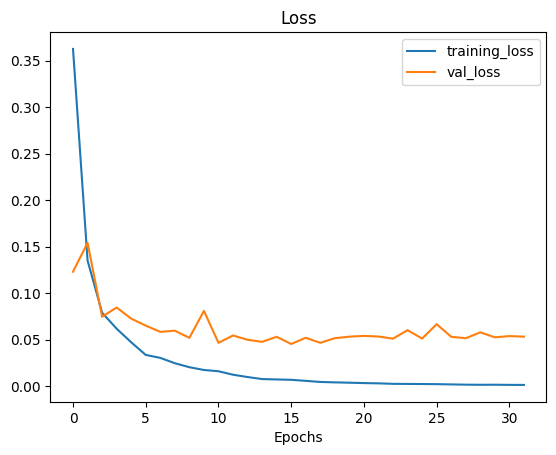

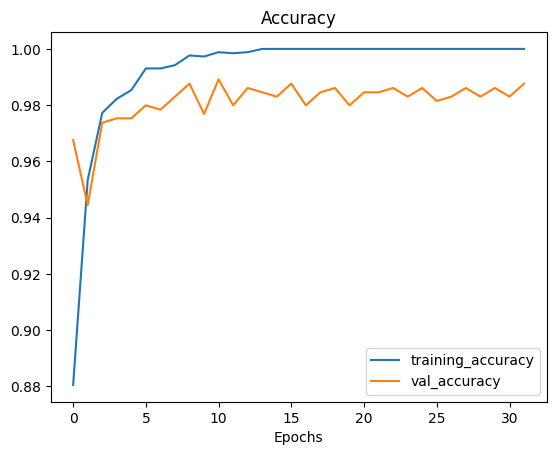

In [65]:
plot_loss_curves(history)

# Evalute model

In [66]:
model.evaluate(test_data)

21/21 [==============================] - 1s 39ms/step - loss: 0.0531 - accuracy: 0.9877


[0.053073372691869736, 0.9876543283462524]

# Best model

In [68]:
"""clone the model"""
# best_model = tf.keras.models.load_model(checkpoint_path)

'clone the model'

# Evalute best model

In [69]:
# best_model.evaluate(test_data)

# Confusion matrix

In [70]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [71]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 24ms/step


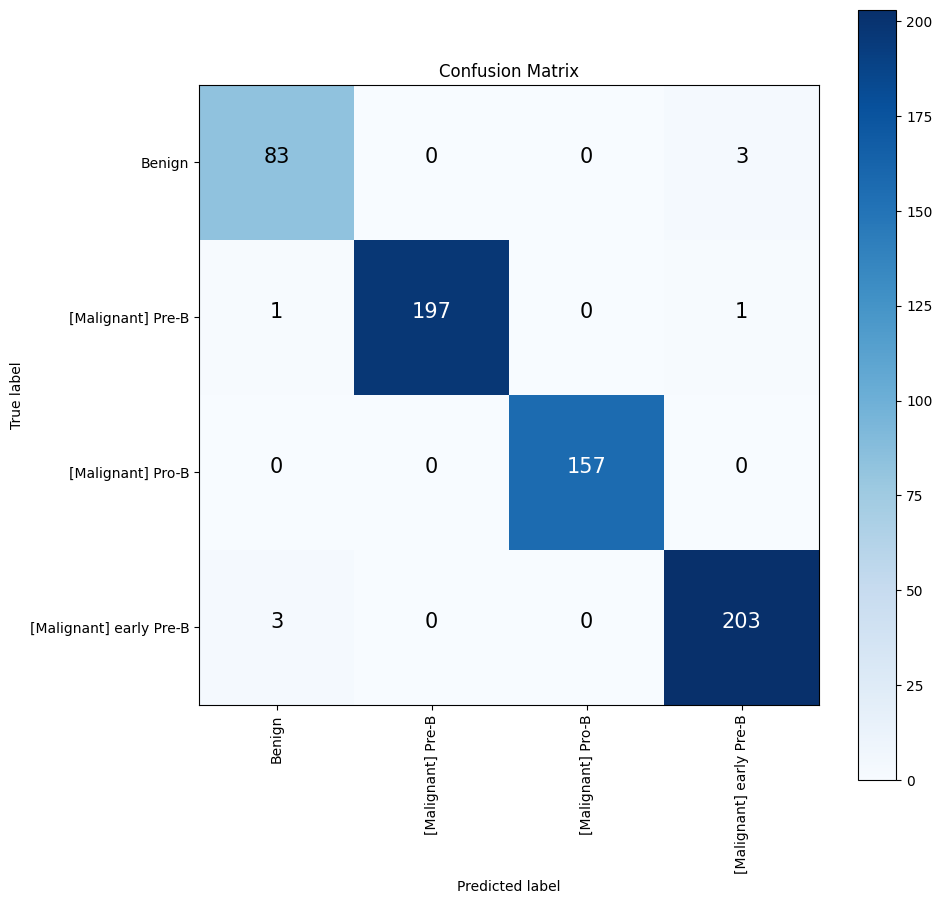

In [39]:
make_confusion_matrix(y_true, y_pred, class_names)

In [76]:
y_pred


array([2., 3., 1., 3., 2., 2., 0., 3., 1., 0., 2., 3., 0., 3., 3., 2., 0.,
       2., 3., 3., 3., 3., 2., 1., 1., 1., 3., 1., 1., 2., 1., 2., 1., 1.,
       3., 1., 3., 0., 3., 1., 1., 1., 0., 1., 1., 1., 1., 2., 2., 3., 3.,
       3., 3., 2., 3., 1., 1., 2., 2., 2., 1., 2., 0., 1., 3., 3., 1., 2.,
       0., 0., 3., 1., 1., 2., 3., 2., 3., 3., 1., 2., 2., 1., 1., 3., 1.,
       3., 2., 2., 3., 3., 0., 2., 2., 1., 1., 0., 1., 0., 2., 3., 0., 3.,
       0., 2., 2., 3., 3., 0., 1., 3., 2., 0., 2., 3., 2., 3., 1., 1., 3.,
       1., 1., 3., 1., 3., 0., 2., 2., 3., 2., 0., 0., 2., 3., 3., 2., 3.,
       1., 3., 1., 1., 1., 0., 1., 3., 3., 2., 1., 3., 1., 3., 3., 3., 1.,
       1., 3., 1., 3., 2., 0., 3., 2., 2., 1., 2., 3., 1., 3., 3., 2., 2.,
       1., 1., 2., 3., 3., 2., 1., 2., 2., 3., 2., 3., 3., 3., 0., 0., 3.,
       1., 0., 3., 1., 3., 3., 1., 1., 3., 1., 2., 2., 3., 3., 1., 0., 2.,
       1., 2., 2., 3., 2., 2., 1., 1., 2., 3., 2., 3., 3., 1., 3., 2., 3.,
       1., 1., 3., 3., 3.

<ipython-input-90-23c45009ffa0>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,4,i+1)


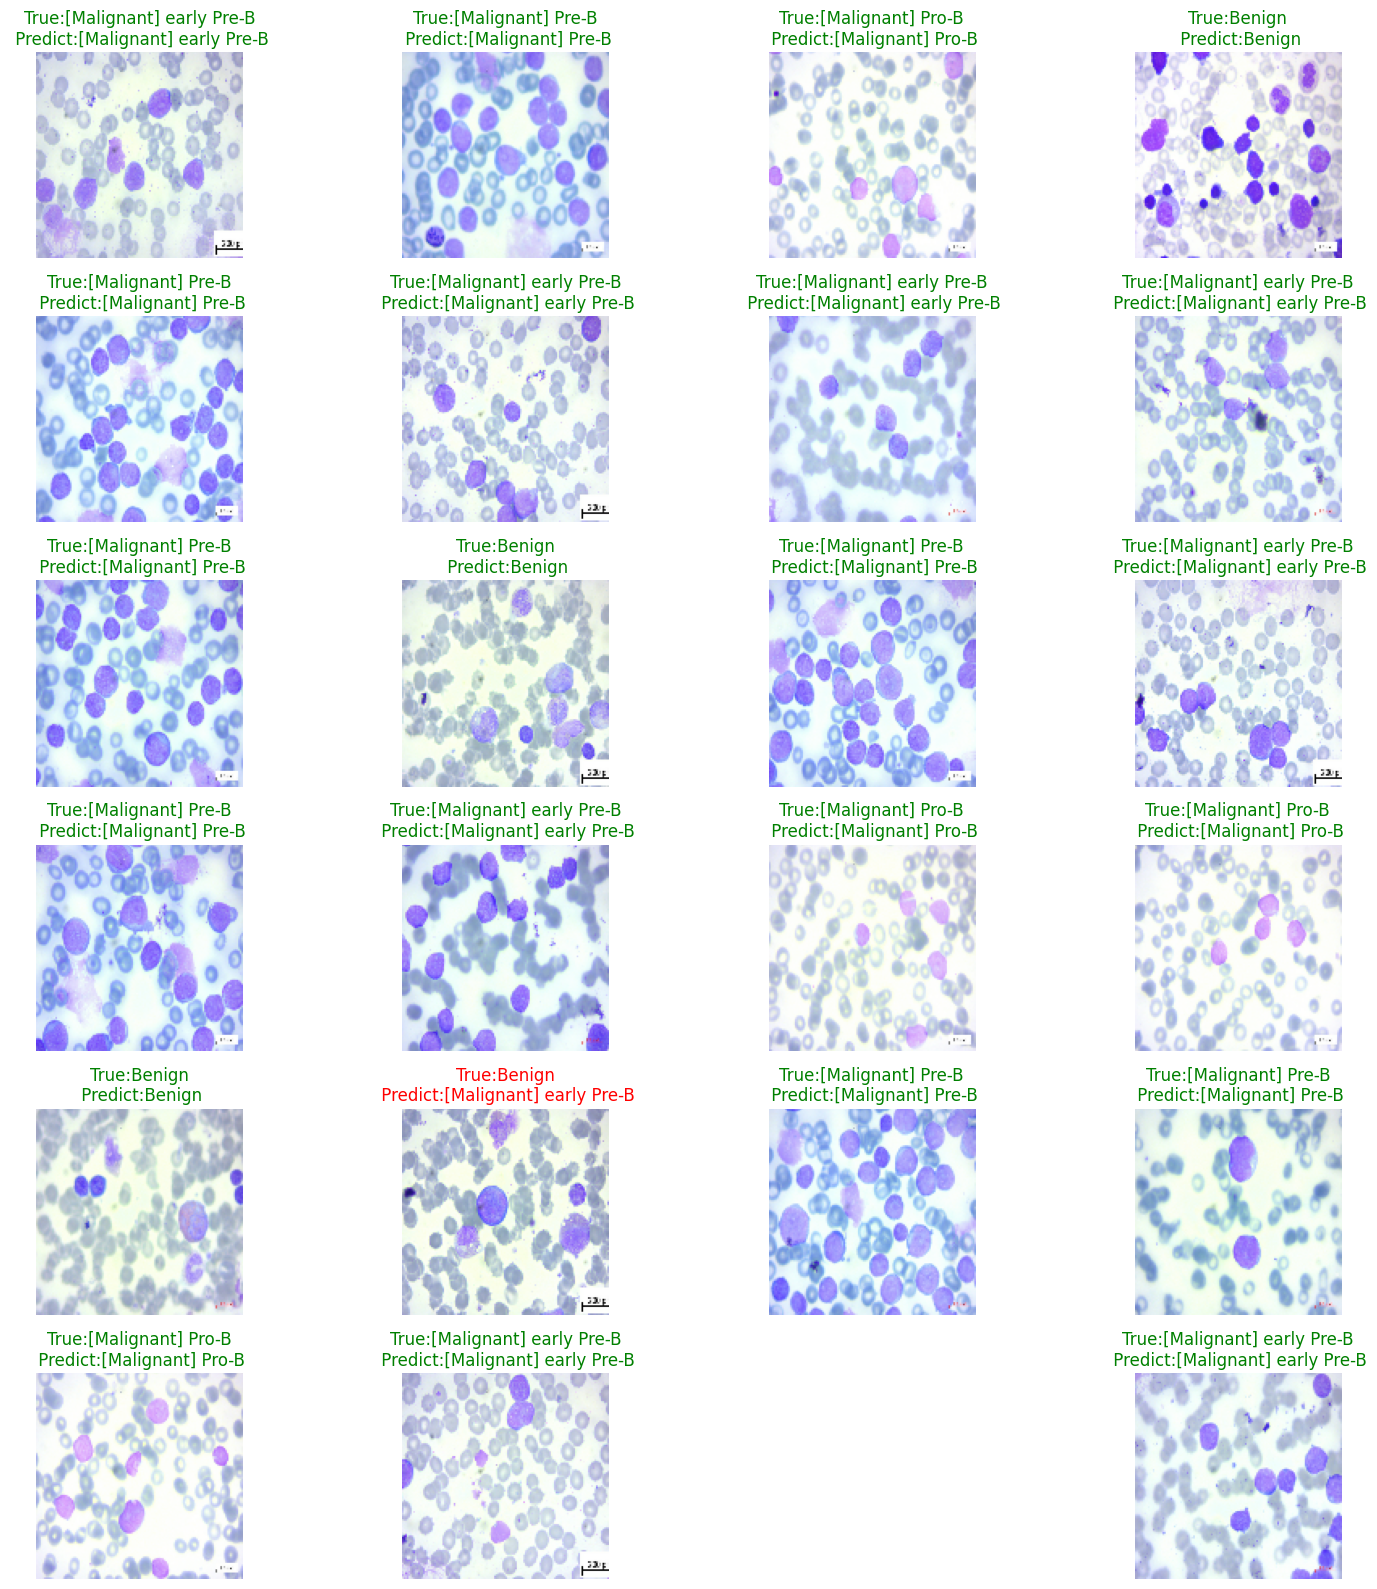

In [90]:
plt.figure(figsize=(16, 16))
for image_batch,label_batch in test_data.take(1):
    for i in range(0,24):
        plt.subplot(6,4,i+1)
        img = image_batch[i].numpy().astype("uint8")
        plt.imshow(img)
        true_class = class_names[np.argmax(label_batch[i])]

        img = np.expand_dims(img, axis= 0)
        predict_class = model.predict(img, verbose=0)
        predict_class = np.argmax(predict_class)
        predict_class = class_names[predict_class]

        title = f"""True:{true_class}\n Predict:{predict_class}"""
        plt.title(title, color='g' if true_class == predict_class else 'r')
        plt.axis("off")
        plt.tight_layout()
plt.show()